In [201]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pymysql
import matplotlib.pyplot as plt
import os
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
weather_df = pd.read_csv('csv_files/weather_data_mrg_20200101_20230531.csv', index_col=0)
elec_df = pd.read_csv('csv_files/generate_data.csv', index_col=0)

In [ ]:
local_data_dic = {'강원': 'Gangwon', '경기': 'Gyeonggi', '경남': 'Gyeongnam', '경북': 'Gyeongbuk', '광주': 'Gwangju', '대구': 'Deagu', '대전': 'Deajeon', '부산': 'Busan', '서울': 'Seoul', '세종': 'Sejong', '울산': 'Ulsan', '인천': 'Incheon', '전남': 'Jeonnam', '전북': 'Jeonbuk', '제주': 'Jeju', '충남': 'Chungnam', '충북': 'Chungbuk'}

for city_name in local_data_dic.keys()
    # 특정 도시의 데이터 추출과 데이터프레임 통합 및 SI(일사)가 0인 부분 제외
    loc_e_df = elec_df[elec_df['LOC']==city_name].reset_index(drop=True)
    loc_w_df = weather_df[weather_df['LOC']==city_name].reset_index(drop=True)
    loc_mrg_df = pd.merge(loc_w_df, loc_e_df[['TM', 'value']], on='TM', how='inner')
    loc_df = loc_mrg_df[loc_mrg_df['SI']!=0].reset_index(drop=True)
    # 데이터 전처리 (중요도)
    raw_X = np.array(loc_df.loc[:,['WS','TA','TD','HM','PV','VS','SS','SI','TS']])
    raw_y = np.array(loc_df[['value']]).reshape(-1,)
    train_X, test_X, train_y, test_y = train_test_split(raw_X, raw_y, test_size=0.2)
    # 하이퍼파라미터 튜닝
    n_estimators_list = [100, 200, 300, 400, 500, 600, 700]
    learning_rate_list = [0.05, 0.07, 0.1, 0,2, 0.3]
    max_depth_list = [6, 7, 8, 9, 10]
    min_child_weight_list = [1, 2, 3]
    reg_alpha_list = [0.1, 1, 10, 100]
    best_model = None
    best_params = None
    best_r2 = -float('inf')
    max_iter = len(n_estimators_list)*len(learning_rate_list)*len(max_depth_list)*len(min_child_weight_list)*len(reg_alpha_list)
    iter = 1

    for n_estimators in n_estimators_list:
        for learning_rate in learning_rate_list:
            for max_depth in max_depth_list:
                for min_child_weight in min_child_weight_list:
                    for reg_alpha in reg_alpha_list:
                        # 훈련
                        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, early_stopping_rounds=20)
                        model.fit(train_X, train_y, eval_set=[(train_X,train_y), (val_X,val_y)], verbose=0)
                        # R2를 기준으로 best_model 저장
                        r2 = model.score(test_X, test_y)
                        if r2>best_r2:
                            best_r2 = r2
                            best_model = model
                            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth, 'min_child_weight': min_child_weight, 'reg_alpha': reg_alpha}
                        # 진행도 출력
                        clear_output(wait=True)
                        print(f'{city_name}: {iter/max_iter*100:.2f}% 완료')
                        iter += 1
    # 기존의 모델과 best_model을 R2를 기준으로 비교하여 모델 저장 
    if os.path.exists(f'xgb_models/{local_data_dic[city_name]}_model.json'):
        cmp_model = XGBRegressor()
        cmp_model.load_model(f'xgb_models/{local_data_dic[city_name]}_model.json')
        if best_model.score(test_X, test_y) > cmp_model.score(test_X, test_y):
            best_model.save_model(f'xgb_models/{local_data_dic[city_name]}_model.json')
    else:
        best_model.save_model(f'xgb_models/{local_data_dic[city_name]}_model.json')

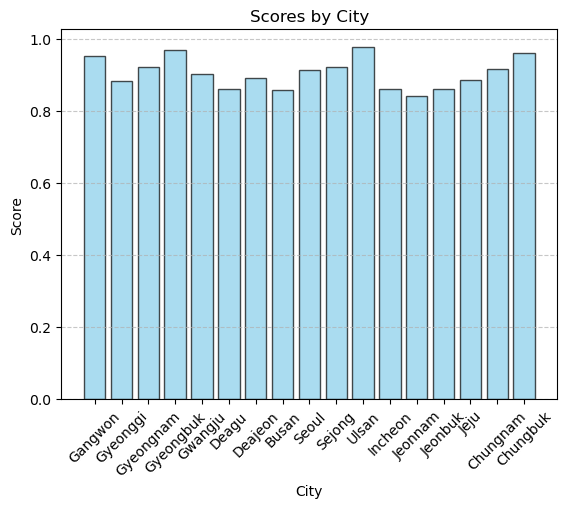

In [193]:
# score 출력
score_list = []

for city_name in local_data_dic.keys():
    loc_e_df = elec_df[elec_df['LOC']==city_name].reset_index(drop=True)
    loc_w_df = weather_df[weather_df['LOC']==city_name].reset_index(drop=True)
    loc_mrg_df = pd.merge(loc_w_df, loc_e_df[['TM', 'value']], on='TM', how='inner')
    loc_df = loc_mrg_df[loc_mrg_df['SI']!=0].reset_index(drop=True)
    raw_X = np.array(loc_df.loc[:,['WS','TA','TD','HM','PV','VS','SS','SI','TS']])
    raw_y = np.array(loc_df[['value']]).reshape(-1,)
    X, test_X, y, test_y = train_test_split(raw_X, raw_y, test_size=0.2)
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)
    tmp_model = XGBRegressor()
    tmp_model.load_model(f'sgb_models/{local_data_dic[city_name]}_model.json')
    score_list.append(tmp_model.score(test_X, test_y))

plt.figure(figsize=(12, 6))
bars = plt.bar(local_data_dic.keys(), score_list, color='skyblue', edgecolor='black', alpha=0.7)
for bar, score in zip(bars, score_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', 
             ha='center', va='bottom', fontsize=12, color='black')
plt.xlabel('City')
plt.ylabel('R2 Score')
plt.title('R2 Scores by City')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('xgb_models/r2_scores_by_city.png')
plt.show()